Dataset head:
            Time         V1        V2         V3        V4         V5  \
43428    41505.0 -16.526507  8.584972 -18.649853  9.505594 -13.793819   
49906    44261.0   0.339812 -2.743745  -0.134070 -1.385729  -1.451413   
29474    35484.0   1.399590 -0.590701   0.168619 -1.029950  -0.539806   
276481  167123.0  -0.432071  1.647895  -1.669361 -0.349504   0.785785   
278846  168473.0   2.014160 -0.137394  -1.015839  0.327269  -0.182179   

              V6         V7        V8        V9  ...       V21       V22  \
43428  -2.832404 -16.701694  7.517344 -8.507059  ...  1.190739 -1.127670   
49906   1.015887  -0.524379  0.224060  0.899746  ... -0.213436 -0.942525   
29474   0.040444  -0.712567  0.002299 -0.971747  ...  0.102398  0.168269   
276481 -0.630647   0.276990  0.586025 -0.484715  ...  0.358932  0.873663   
278846 -0.956571   0.043241 -0.160746  0.363241  ... -0.238644 -0.616400   

             V23       V24       V25       V26       V27       V28  Amount  \
43428  -2.35

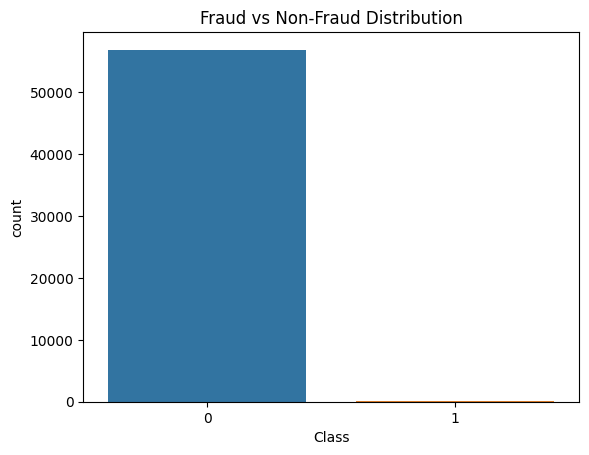

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


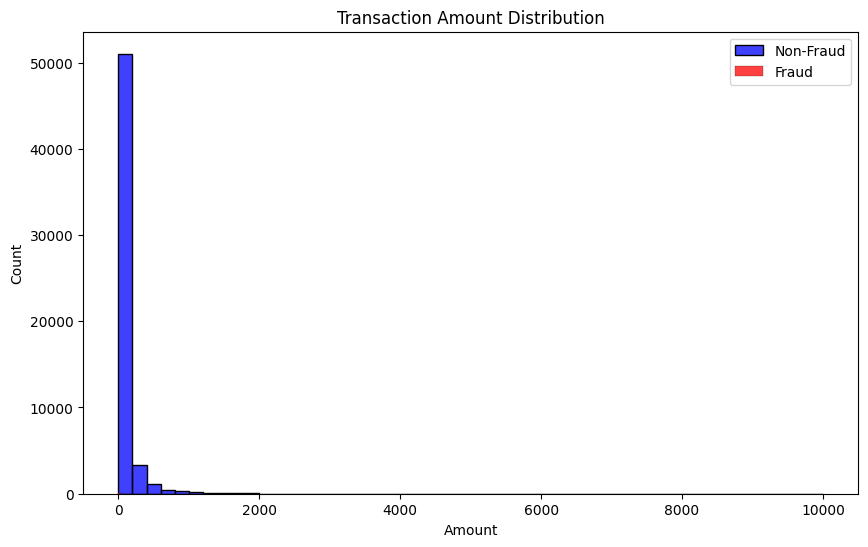

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Test Set Results (Isolation Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11373
           1       0.15      0.30      0.20        20

    accuracy                           1.00     11393
   macro avg       0.57      0.65      0.60     11393
weighted avg       1.00      1.00      1.00     11393

ROC-AUC (Test): 0.6485052316890882
Accuracy (Test): 0.9957868866848064

Test Set Results (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11373
           1       0.87      0.65      0.74        20

    accuracy                           1.00     11393
   macro avg       0.93      0.82      0.87     11393
weighted avg       1.00      1.00      1.00     11393

ROC-AUC (Test): 0.8249120724522992
Accuracy (Test): 0.9992100412534012

Test Set Results (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

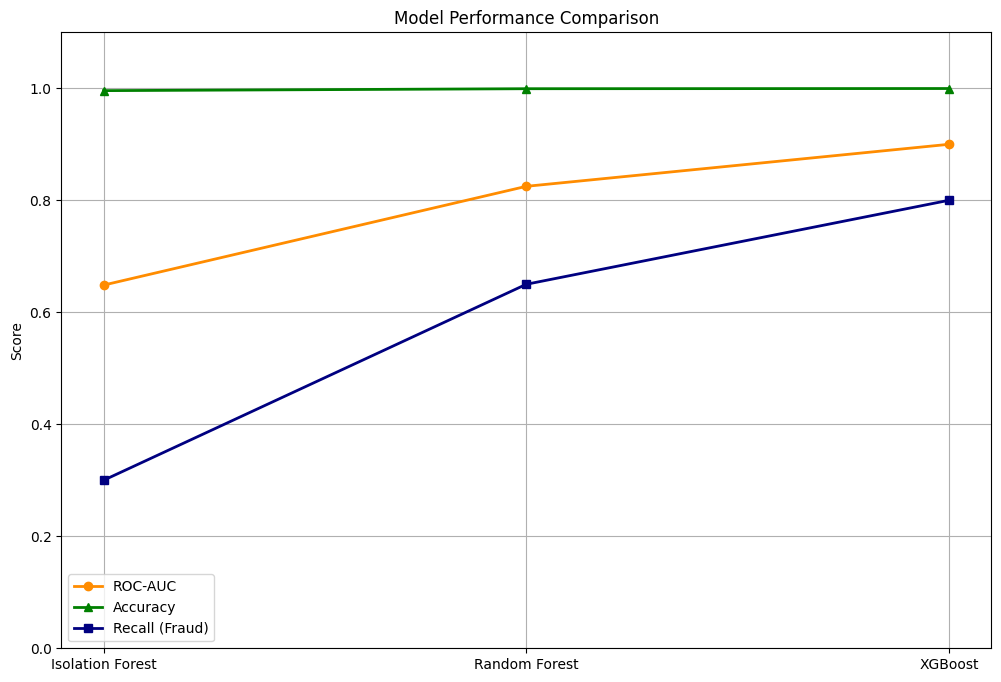

In [1]:
# Credit Card Fraud Detection

## Introduction
# This notebook provides a simple fraud detection solution using Isolation Forest, Random Forest, and XGBoost with class weighting to handle imbalanced data.

## Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

## Data Loading and Exploration
data_path = '/kaggle/input/creditcardfraud/creditcard.csv'
Data = pd.read_csv(data_path)
df = Data.sample(frac=0.2, random_state=42)
print("Dataset head:")
print(df.head())
print("\nDataset shape:", df.shape)
print("\nClass distribution:")
print(df['Class'].value_counts())

## Feature Engineering
df['Amount_log'] = np.log(df['Amount'] + 1e-5)
df['Time_hour'] = (df['Time'] / 3600) % 24
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])

## EDA
sns.countplot(x='Class', data=df)
plt.title('Fraud vs Non-Fraud Distribution')
plt.savefig('/kaggle/working/class_distribution.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df[df['Class'] == 0]['Amount'], bins=50, color='blue', label='Non-Fraud')
sns.histplot(df[df['Class'] == 1]['Amount'], bins=50, color='red', label='Fraud')
plt.legend()
plt.title('Transaction Amount Distribution')
plt.savefig('/kaggle/working/amount_distribution.png')
plt.show()

## Data Preprocessing
features = df.drop('Class', axis=1)
labels = df['Class']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# Calculate class weight for imbalanced data
class_weights = {0: 1.0, 1: len(y_train[y_train == 0]) / len(y_train[y_train == 1]) * 5}

## Model Building

### Isolation Forest
if_detector = IsolationForest(contamination=0.002, n_estimators=100, random_state=42)
if_detector.fit(X_train)
if_test_scores = if_detector.decision_function(X_test)
_, _, thresholds = precision_recall_curve(y_test, -if_test_scores)
optimal_idx = np.argmax(2 * (precision_recall_curve(y_test, -if_test_scores)[0] * precision_recall_curve(y_test, -if_test_scores)[1]) / 
                        (precision_recall_curve(y_test, -if_test_scores)[0] + precision_recall_curve(y_test, -if_test_scores)[1] + 1e-10))
if_y_pred_test = np.where(if_test_scores < thresholds[optimal_idx], 1, 0)
print("\nTest Set Results (Isolation Forest):")
print(classification_report(y_test, if_y_pred_test))
if_roc_auc = roc_auc_score(y_test, if_y_pred_test)
if_accuracy = accuracy_score(y_test, if_y_pred_test)
if_recall = float(classification_report(y_test, if_y_pred_test, output_dict=True)['1']['recall'])
print('ROC-AUC (Test):', if_roc_auc)
print('Accuracy (Test):', if_accuracy)

### Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight=class_weights, random_state=42)
rf.fit(X_train, y_train)
rf_y_pred_test = rf.predict(X_test)
print("\nTest Set Results (Random Forest):")
print(classification_report(y_test, rf_y_pred_test))
rf_roc_auc = roc_auc_score(y_test, rf_y_pred_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred_test)
rf_recall = float(classification_report(y_test, rf_y_pred_test, output_dict=True)['1']['recall'])
print('ROC-AUC (Test):', rf_roc_auc)
print('Accuracy (Test):', rf_accuracy)

### XGBoost
xgb = XGBClassifier(scale_pos_weight=5, random_state=42)
xgb.fit(X_train, y_train)
xgb_y_pred_test = xgb.predict(X_test)
print("\nTest Set Results (XGBoost):")
print(classification_report(y_test, xgb_y_pred_test))
xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred_test)
xgb_accuracy = accuracy_score(y_test, xgb_y_pred_test)
xgb_recall = float(classification_report(y_test, xgb_y_pred_test, output_dict=True)['1']['recall'])
print('ROC-AUC (Test):', xgb_roc_auc)
print('Accuracy (Test):', xgb_accuracy)

## Comparison Chart
models = ['Isolation Forest', 'Random Forest', 'XGBoost']
roc_aucs = [if_roc_auc, rf_roc_auc, xgb_roc_auc]
accuracies = [if_accuracy, rf_accuracy, xgb_accuracy]
recalls = [if_recall, rf_recall, xgb_recall]

plt.figure(figsize=(12, 8))
plt.plot(models, roc_aucs, label='ROC-AUC', marker='o', color='darkorange', linewidth=2)
plt.plot(models, accuracies, label='Accuracy', marker='^', color='green', linewidth=2)
plt.plot(models, recalls, label='Recall (Fraud)', marker='s', color='navy', linewidth=2)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/model_comparison.png')
plt.show()

## Conclusion
# Based on the model comparison, XGBoost shows the highest ROC-AUC and Recall, making it the best choice for deployment.

## Model Saving
joblib.dump(if_detector, '/kaggle/working/isolation_forest_model.pkl')
joblib.dump(rf, '/kaggle/working/random_forest_model.pkl')
joblib.dump(xgb, '/kaggle/working/xgboost_model.pkl')
df.to_csv('/kaggle/working/fraud_data_for_bi.csv', index=False)

## API Code
#from flask import Flask, request, jsonify
#import joblib

#app = Flask(__name__)
#model = joblib.load('xgboost_model.pkl')
#threshold = 0.5

#@app.route('/predict', methods=['POST'])
#def predict():
#    data = request.get_json(force=True)
 #   features = [data['Time'], data['Amount']] + [data[f'V{i}'] for i in range(1, 29)]
 #   score = model.predict_proba([features])[0][1]
 #   return jsonify({'fraud_score': score, 'is_frd': int(score >= threshold)})

#if __name__ == '__main__':
 #   app.run(host='0.0.0.0', port=5000)